In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow 
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB0, EfficientNetB1,EfficientNetB2, EfficientNetB6,EfficientNetB7, DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools


%matplotlib inline

In [ ]:
train_dir = "/content/drive/MyDrive/ML Project/Pneumonia/train"
valid_dir = "/content/drive/MyDrive/ML Project/Pneumonia/valid"
test_dir = "/content/drive/MyDrive/ML Project/Pneumonia/test"

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpeg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

normal_train = np.array(Dataset_loader('/content/drive/MyDrive/ML Project/Pneumonia/train/NORMAL',224))
pneumonia_train = np.array(Dataset_loader('/content/drive/MyDrive/ML Project/Pneumonia/train/PNEUMONIA',224))
normal_test = np.array(Dataset_loader('/content/drive/MyDrive/ML Project/Pneumonia/test/NORMAL',224))
pneumonia_test = np.array(Dataset_loader('/content/drive/MyDrive/ML Project/Pneumonia/test/PNEUMONIA',224))

In [ ]:
normal_train

In [ ]:
normal_train_label = np.zeros(len(normal_train))
pneumonia_train_label = np.ones(len(pneumonia_train))

X_train = np.concatenate((normal_train, pneumonia_train), axis = 0)
Y_train = np.concatenate((normal_train_label, pneumonia_train_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

Y_train = to_categorical(Y_train, num_classes= 2)



normal_test_label = np.zeros(len(normal_test))
pneumonia_test_label = np.ones(len(pneumonia_test))

X_test = np.concatenate((normal_test, pneumonia_test), axis = 0)
Y_test = np.concatenate((normal_test_label, pneumonia_test_label), axis = 0)

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]


Y_test = to_categorical(Y_test, num_classes= 2)


In [ ]:
Y_train

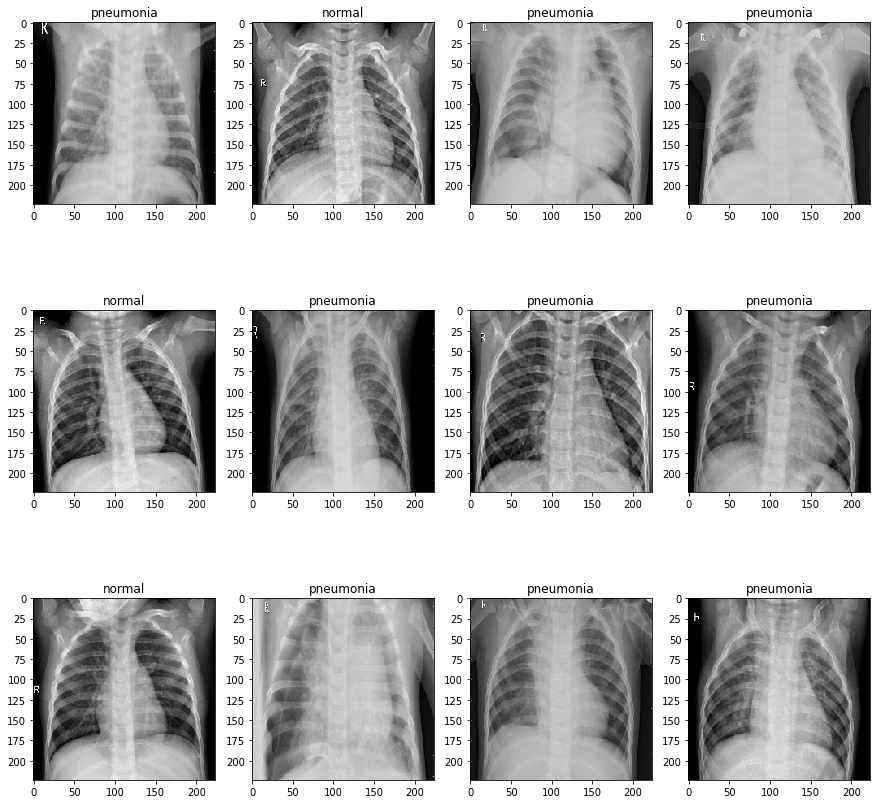

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('normal')
    else:
        ax.title.set_text('pneumonia')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [ ]:

train_generator = ImageDataGenerator(
        zoom_range=2,  
        horizontal_flip=True,  
        vertical_flip=True, 
    )

# EfficientNet

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

EfficientNet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


In [ ]:

model = build_model(EfficientNet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,057,253
Trainable params: 4,012,670
Non-trainable params: 44,583
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

### Test Data Evaluation 

In [ ]:
history = model.fit_generator(
    train_generator.flow(X_train, Y_train, batch_size=4),
    steps_per_epoch=X_train.shape[0] / 4,
    epochs=50,
    validation_data=(X_test, Y_test),
    callbacks=[learn_control, checkpoint]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
1304/1304 [==============================] - 187s 113ms/step - loss: 0.5303 - accuracy: 0.7621 - val_loss: 0.3877 - val_accuracy: 0.8317

Epoch 00001: val_accuracy improved from -inf to 0.83173, saving model to weights.best.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
1304/1304 [==============================] - 144s 111ms/step - loss: 0.3940 - accuracy: 0.8367 - val_loss: 0.4308 - val_accuracy: 0.8381

Epoch 00002: val_accuracy improved from 0.83173 to 0.83814, saving model to weights.best.hdf5
Epoch 3/50
1304/1304 [==============================] - 144s 111ms/step - loss: 0.3727 - accuracy: 0.8508 - val_loss: 0.3274 - val_accuracy: 0.8798

Epoch 00003: val_accuracy improved from 0.83814 to 0.87981, saving model to weights.best.hdf5
Epoch 4/50
1304/1304 [==============================] - 144s 110ms/step - loss: 0.3577 - accuracy: 0.8620 - val_loss: 0.3021 - val_accuracy: 0.8878

Epoch 00004: val_accuracy improved from 0.87981 to 0.88782, saving model to weights.best.hdf5
Epoch 5/50
1304/1304 [==============================] - 144s 110ms/step - loss: 0.3250 - accuracy: 0.8719 - val_loss: 0.2924 - val_accuracy: 0.9054

Epoch 00005: val_accuracy improved from 0.88782 to 0.90545, saving model to weights.best.hdf5
Epoch 6/50
1304/1304 [======

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

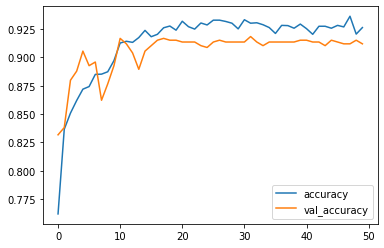

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

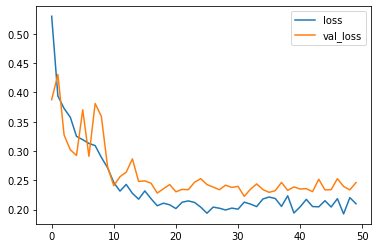

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
Y_val_pred = model.predict(X_test)
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_val_pred, axis=1))

0.9118589743589743

# DenseNet

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

EfficientNet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
model = build_model(EfficientNet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 7,043,650
Trainable params: 6,957,954
Non-trainable params: 85,696
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(X_train, Y_train, batch_size=4),
    steps_per_epoch=X_train.shape[0] / 4,
    epochs=50,
    validation_data=(X_test, Y_test),
    callbacks=[learn_control, checkpoint]
)